In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import healpy as hp

In [2]:
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as mb

In [7]:
dbroot = '/astro/store/pogo4/opsim/fbs_db/fbs_1.7/baseline'

baselinedir = os.path.join(dbroot, 'baseline')
baseline = 'baseline_nexp2_v1.7_10yrs'
runName = baseline


In [8]:
outDir = 'overlap_test'

In [9]:
countbins = np.arange(0, 11, 1)
countbins = list(countbins) + [15, 20, 200]
countbins = np.array(countbins)

In [169]:
bundles = {}

# Histogram the number of visits per night.
metric = metrics.NVisitsPerNightMetric(nightCol='night', bins=countbins,
                                       metricName="NVisitsPerNight")
slicerSmall = slicers.HealpixSlicer(nside=64, radius=0.75)
slicerNormal = slicers.HealpixSlicer(nside=64, radius=1.75)
plotDict = {'bins': countbins, 'xlabel': 'Number of visits each night'}
plotFunc = plots.SummaryHistogram()

constraint = 'note like "blob%"' # Can add a night to check that the 'small' slicer doesn't overlap
constraint = 'night>80 and night<85 and note like "blob%"'

bundles['small'] = mb.MetricBundle(metric, slicerSmall, constraint, plotDict=plotDict, runName=runName, 
                                   metadata='points', plotFuncs=[plotFunc])
bundles['normal'] = mb.MetricBundle(metric, slicerNormal, constraint, plotDict=plotDict, runName=runName, 
                                   metadata='circles', plotFuncs=[plotFunc])
opsdb = db.OpsimDatabase(os.path.join(dbroot, runName+".db"))
g = mb.MetricBundleGroup({1: bundles['small'], 2: bundles['normal']}, opsdb, outDir=outDir, resultsDb=None)
g.runAll()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint night>80 and night<85 and note like "blob%" for columns ['fieldRA', 'fieldDec', 'night']
Found 1734 visits
Running:  [1]
Completed metric generation.
Running:  [2]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [170]:
def squish_hist(metricValue):
    # Change an array of arrays (dtype=object) to a 2-d array of correct dtype
    mV = np.array(metricValue.compressed().tolist(), dtype=[('metricValue', int)])
    # Make an array to hold the combined result
    finalHist = np.zeros(mV.shape[1], dtype=float)
    # Loop over each bin and use the selected metric to combine the results
    for i in np.arange(finalHist.size):
        finalHist[i] = mV[:, i]['metricValue'].sum()
    return finalHist

def subval_hist(metricValue, i):
    # Pull out the value at one bin
    finalVal = np.zeros(len(metricValue), float)
    for j, (mV, mVmask) in enumerate(zip(metricValue, metricValue.mask)):
        if mVmask:
            finalVal[j] = hp.UNSEEN
        else:
            finalVal[j] = mV[i]
    return finalVal

In [171]:
ph = plots.PlotHandler(outDir=outDir, savefig=False, thumbnail=False, figformat='png')

No handles with labels found to put in legend.


Text(0.5, 1.0, '')

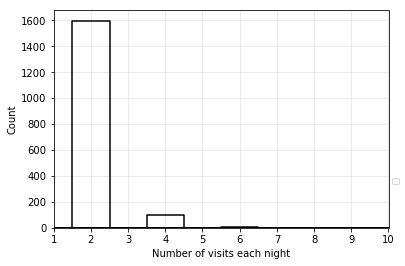

In [172]:
bu = [bundles['small']]#, bundles['normal']]
ph.setMetricBundles(bu)
colors = ['k', 'b', 'c', 'g', 'y', 'r', 'm']
for i, p in enumerate(bundles):
    bundles[p].setPlotDict({'color': colors[i % len(colors)]})
ph.plot(plotFunc=plots.SummaryHistogram(), plotDicts={'metricReduce': metrics.SumMetric(),
        'yMin': 0, 'yMax':None, 'xMin':1, 'xMax': 10, 'legendloc': (1.01, .2)})
#plt.xticks(countbins)
#plt.xlim(1, 15)
#plt.ylim(0, 200)
plt.title("")

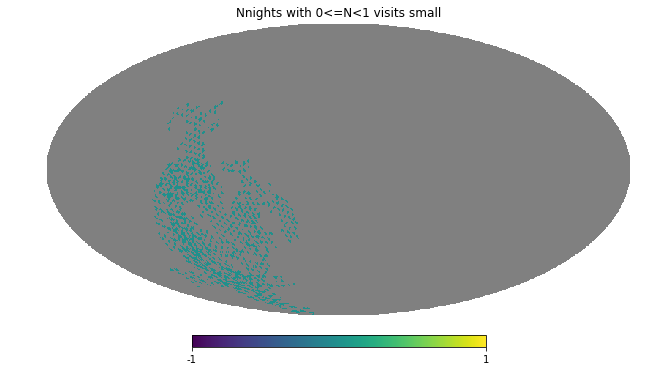

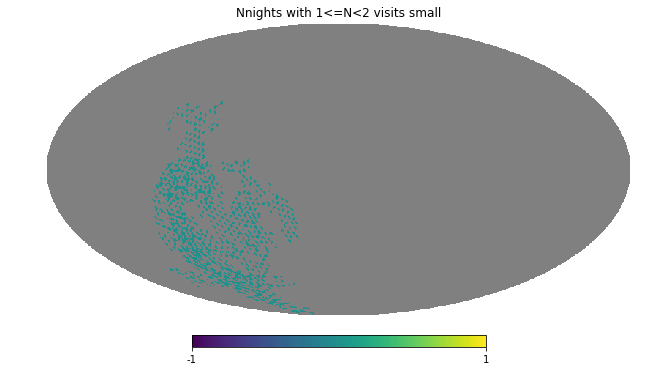

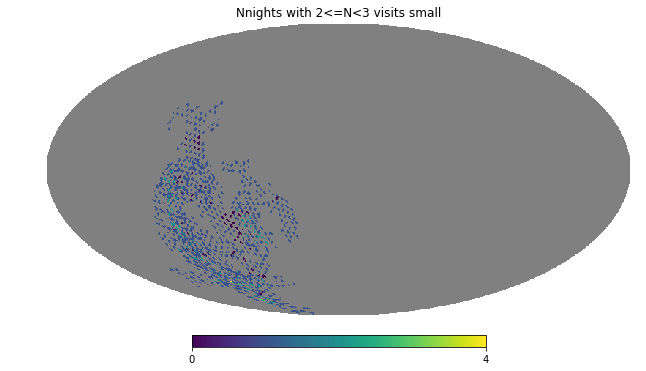

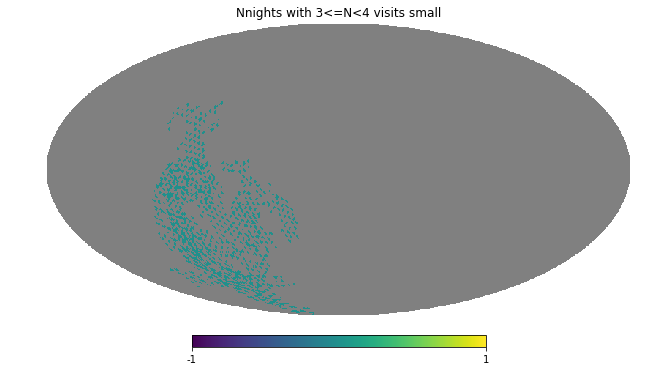

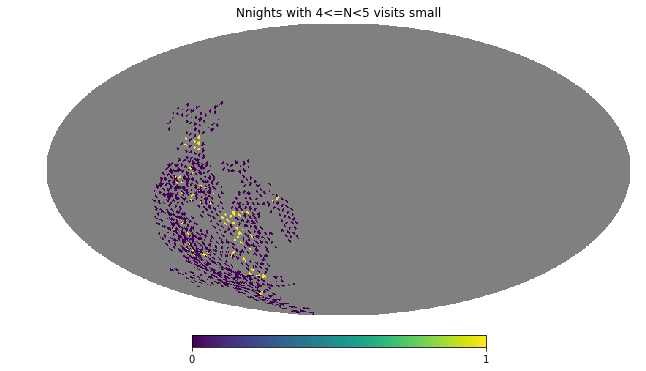

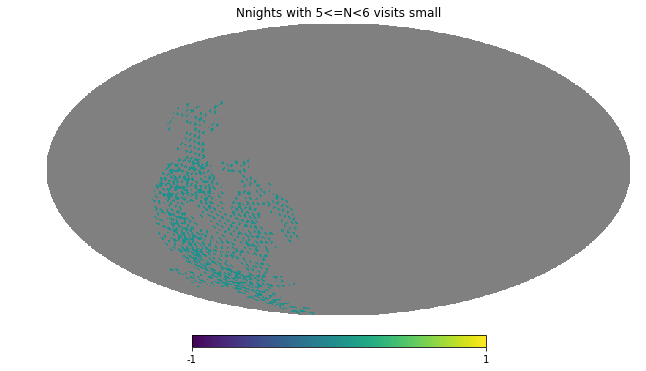

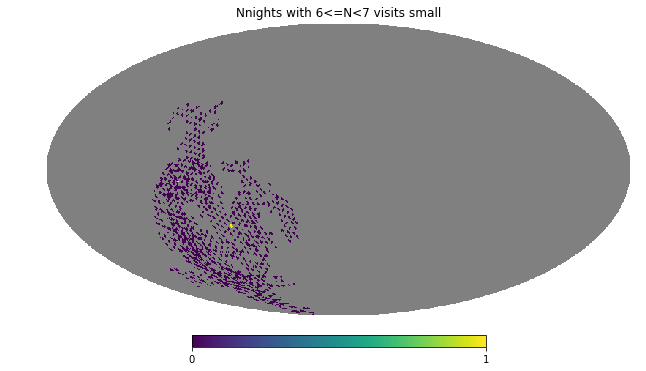

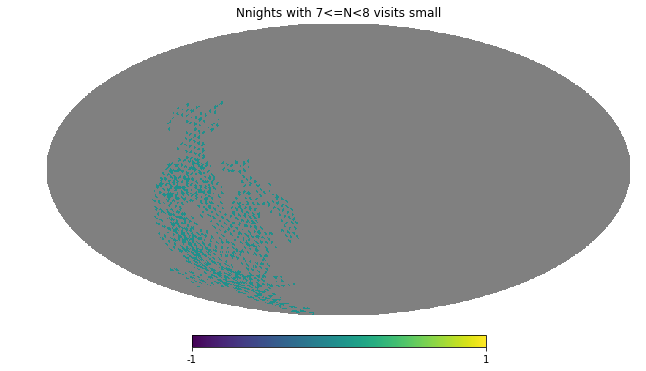

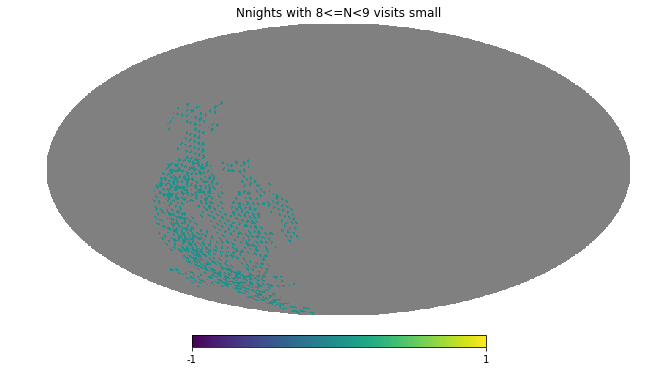

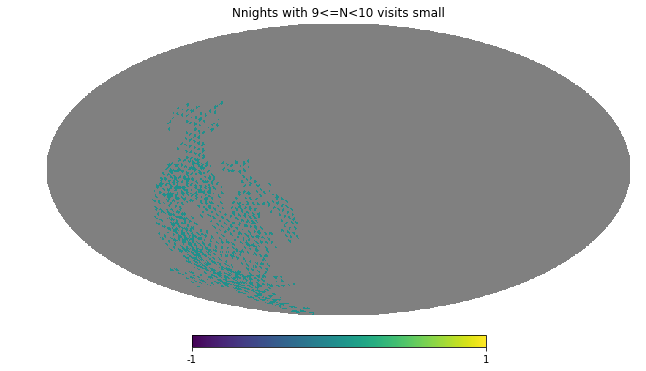

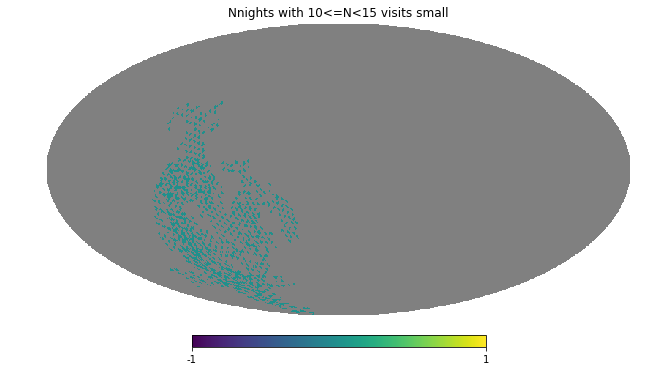

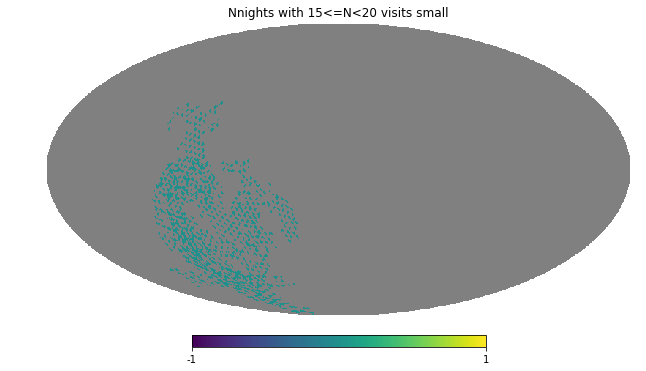

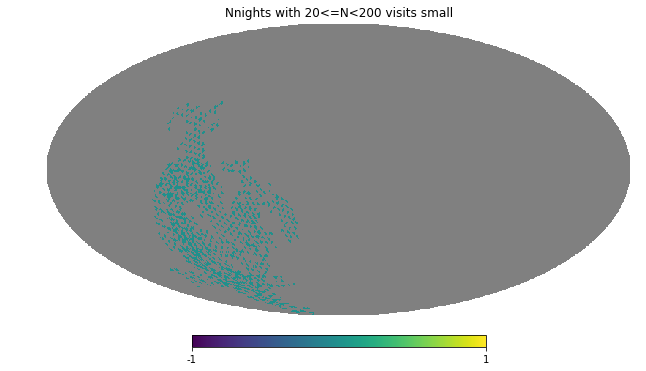

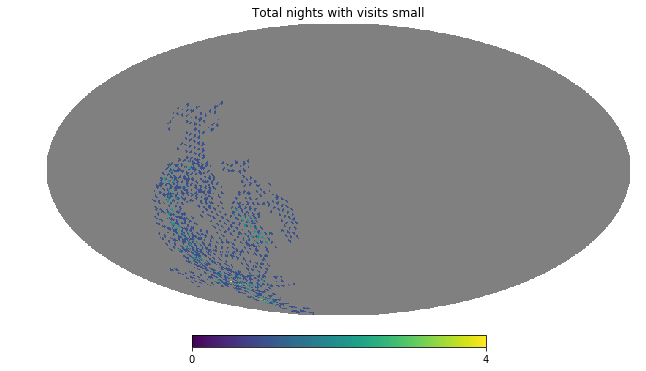

In [175]:
run = 'small'
t = np.zeros(len(bundles[run].metricValues))
for i in range(len(countbins)-1):
    v = subval_hist(bundles[run].metricValues, i)
    t += v
    hp.mollview(v, title=f'Nnights with {countbins[i]}<=N<{countbins[i+1]} visits {run}', min=0, max=None)
t = np.where(t<0, hp.UNSEEN, t)
hp.mollview(t, title=f'Total nights with visits {run}', min=0, max=None)

In [176]:
v = subval_hist(bundles['small'].metricValues, 2)
a = v[np.where(v>0)]
v = subval_hist(bundles['small'].metricValues, 3)
for i in range(4, len(countbins)-1):
    v += subval_hist(bundles['small'].metricValues, i)
b = v[np.where(v>0)]
print(a, b, len(a), len(b), len(b)/len(a), a.sum(), b.sum(), b.sum()/a.sum() )

[1. 1. 1. ... 1. 1. 1.] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 1478 107 0.07239512855209743 1597.0 107.0 0.0670006261740764


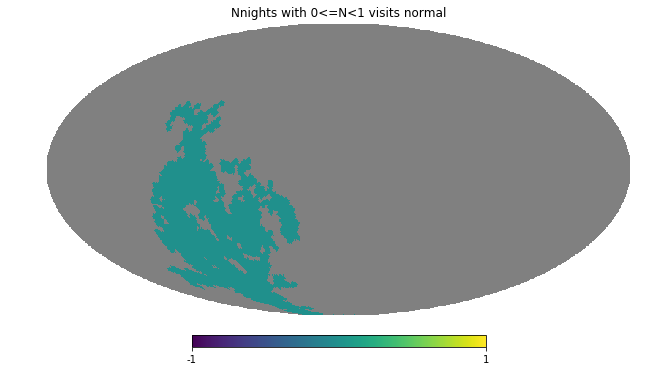

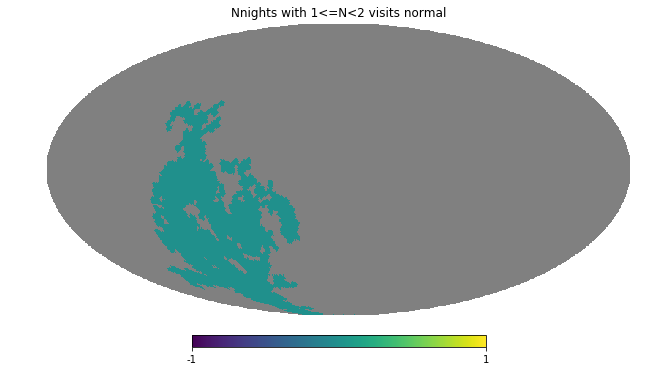

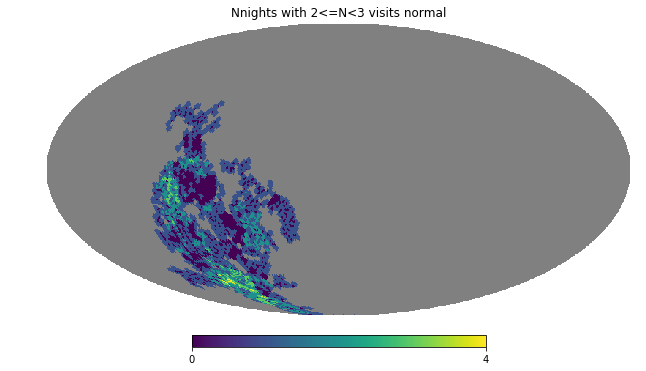

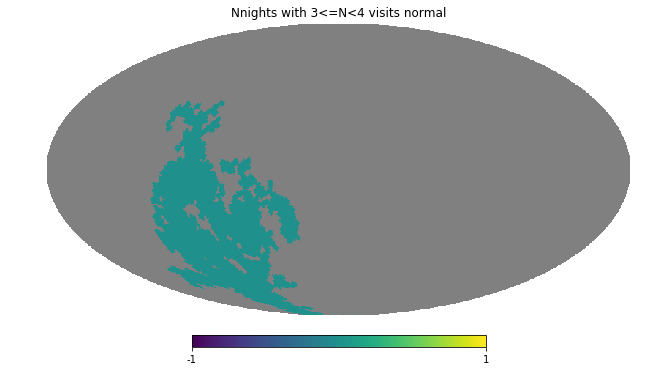

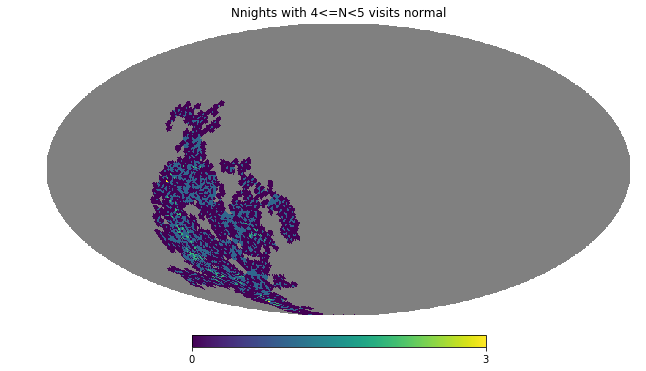

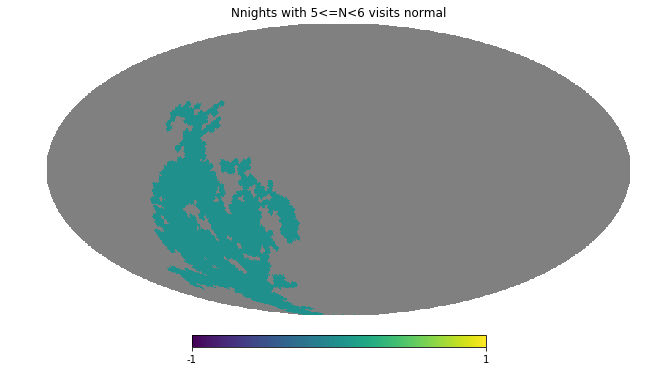

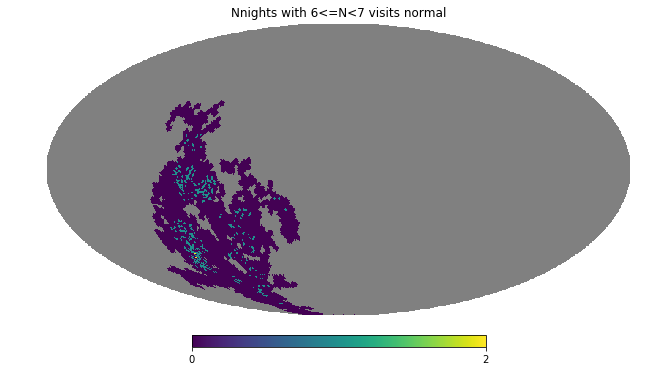

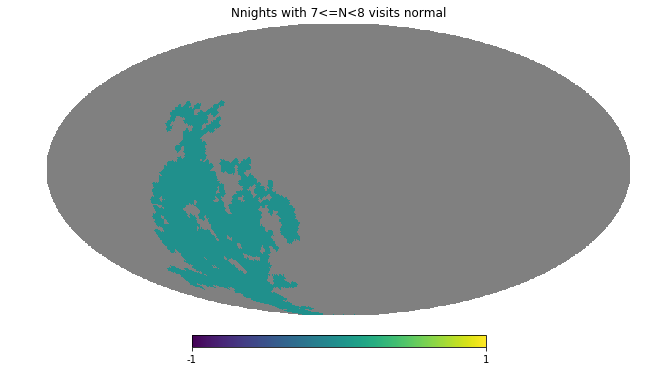

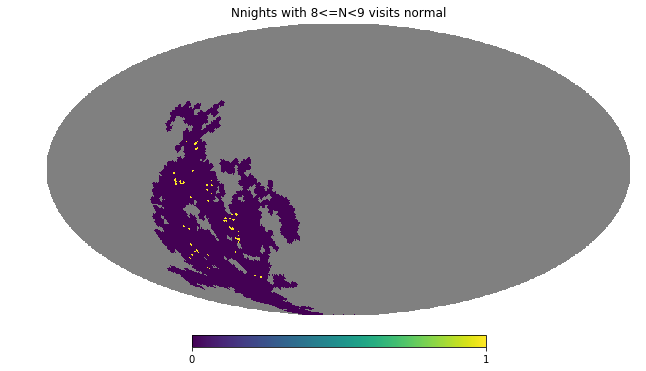

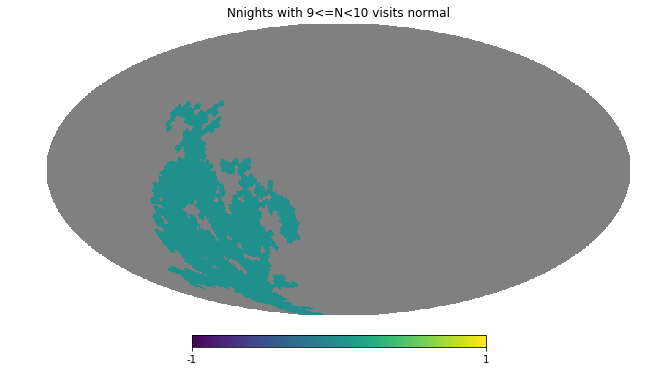

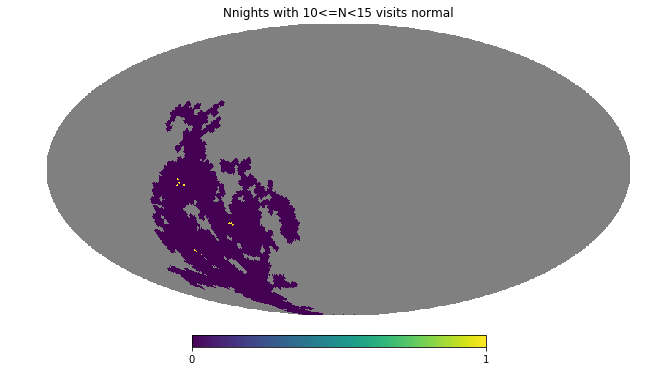

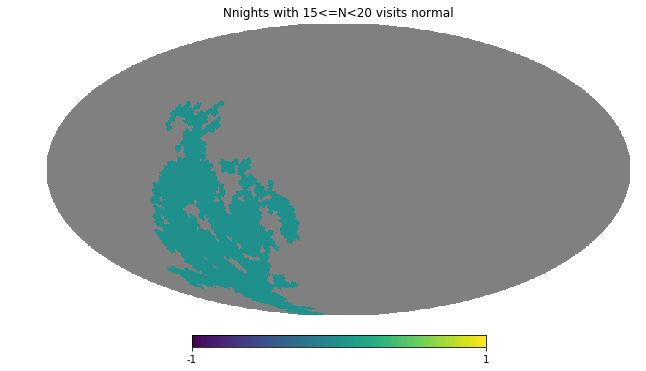

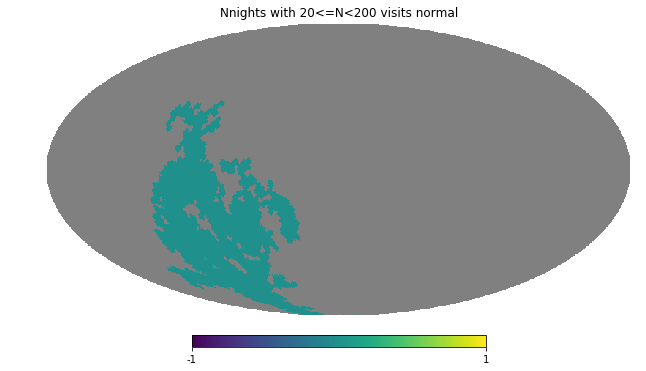

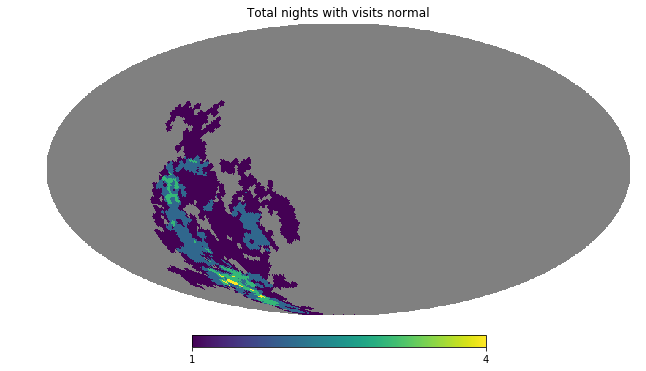

In [177]:
run = 'normal'
t = np.zeros(len(bundles[run].metricValues))
for i in range(len(countbins)-1):
    v = subval_hist(bundles[run].metricValues, i)
    t += v
    hp.mollview(v, title=f'Nnights with {countbins[i]}<=N<{countbins[i+1]} visits {run}')
t = np.where(t<0, hp.UNSEEN, t)
hp.mollview(t, title=f'Total nights with visits {run}')

In [178]:
v = subval_hist(bundles['normal'].metricValues, 2)
a = v[np.where(v>0)]
v = subval_hist(bundles['normal'].metricValues, 3)
for i in range(4, len(countbins)-1):
    v += subval_hist(bundles['normal'].metricValues, i)
b = v[np.where(v>0)]
print(a, b, a.sum(), b.sum(), b.sum()/a.sum() )

[1. 1. 1. ... 1. 1. 1.] [1. 1. 1. ... 2. 1. 1.] 5256.0 2100.0 0.3995433789954338


## comments

a = the healpix map of the points which received exactly two visits in a night (and the value at each point = how many nights received 2 visits). 
b = the healpix map of the points which received more than two visits in a night (and the number of nights with more than 2 visits, at each point). 
The length of a and the length of b tell you how many healpixels qualified in each case (2 visits/night or >2 visits/night). 
The *sum* of a and b tell you how many nights at each healpix point qualified .. and by taking the sum of each and then dividing them, we can find the ratio of how many points/nights got only 2 visits and how many got >2 visits.

By doing this for the 'small' slicer, which removes the effect of field overlaps, we can see how often fields were repeated in a night (i.e. scheduled for >2 visits).
With the 'normal' slicer, we can include both the scheduler revisiting fields >2 times AND the effect of field overlaps.

Looking at a single night, it looks like on nights with a high fraction of field revisits (such as night 89), we have a lower relative contribution from field overlaps. On a more typical night, such as night 50, we have a larger contribution from overlaps and smaller from the scheduler. 

Over the entire survey, we find about 9% of the fields are rescheduled for more than 2 visits, but 45% of the time a field gets more than 2 visits in a night -- the 36% or so boost is due to field overlap. Obviously, the effect of field overlap will also vary depending on how 'blobs' are scheduled on the sky -- more contiguous fields will mean more overlap effect.

Note that this all is applied to the blobs only -- the greedy survey or other minisurveys may contribute as well. 

In [179]:
bundles = {}

# Histogram the number of visits per night.
metric = metrics.NVisitsPerNightMetric(nightCol='night', bins=countbins,
                                       metricName="NVisitsPerNight")
slicerSmall = slicers.HealpixSlicer(nside=64, radius=0.75)
slicerNormal = slicers.HealpixSlicer(nside=64, radius=1.75)
plotDict = {'bins': countbins, 'xlabel': 'Number of visits each night'}
plotFunc = plots.SummaryHistogram()

constraint = 'note like "blob%"' # Can add a night to check that the 'small' slicer doesn't overlap

bundles['small'] = mb.MetricBundle(metric, slicerSmall, constraint, plotDict=plotDict, runName=runName, 
                                   metadata='points', plotFuncs=[plotFunc])
bundles['normal'] = mb.MetricBundle(metric, slicerNormal, constraint, plotDict=plotDict, runName=runName, 
                                   metadata='circles', plotFuncs=[plotFunc])
opsdb = db.OpsimDatabase(os.path.join(dbroot, runName+".db"))
g = mb.MetricBundleGroup({1: bundles['small'], 2: bundles['normal']}, opsdb, outDir=outDir, resultsDb=None)
g.runAll()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint note like "blob%" for columns ['fieldRA', 'fieldDec', 'night']
Found 1675167 visits
Running:  [1]
Completed metric generation.
Running:  [2]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


No handles with labels found to put in legend.


Text(0.5, 1.0, '')

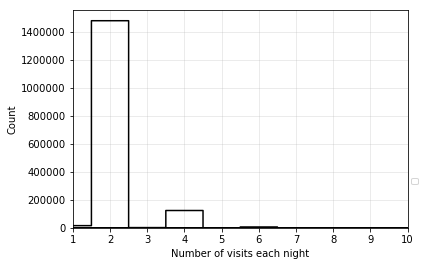

In [180]:
ph = plots.PlotHandler(outDir=outDir, savefig=False, thumbnail=False, figformat='png')
bu = [bundles['small']]#, bundles['normal']]
ph.setMetricBundles(bu)
colors = ['k', 'b', 'c', 'g', 'y', 'r', 'm']
for i, p in enumerate(bundles):
    bundles[p].setPlotDict({'color': colors[i % len(colors)]})
ph.plot(plotFunc=plots.SummaryHistogram(), plotDicts={'metricReduce': metrics.SumMetric(),
        'yMin': 0, 'yMax':None, 'xMin':1, 'xMax': 10, 'legendloc': (1.01, .2)})
plt.title("")

In [181]:
v = subval_hist(bundles['small'].metricValues, 2)
a = v[np.where(v>0)]
v = subval_hist(bundles['small'].metricValues, 3)
for i in range(4, len(countbins)-1):
    v += subval_hist(bundles['small'].metricValues, i)
b = v[np.where(v>0)]
print(a, b, len(a), len(b), len(b)/len(a), a.sum(), b.sum(), b.sum()/a.sum() )

[ 2.  1. 10. ... 25. 21. 24.] [2. 1. 1. ... 1. 1. 3.] 32025 29138 0.9098516783762686 1480282.0 131445.0 0.08879726970942023


In [182]:
v = subval_hist(bundles['normal'].metricValues, 2)
a = v[np.where(v>0)]
v = subval_hist(bundles['normal'].metricValues, 3)
for i in range(4, len(countbins)-1):
    v += subval_hist(bundles['normal'].metricValues, i)
b = v[np.where(v>0)]
print(a, b, len(a), len(b), len(b)/len(a), a.sum(), b.sum(), b.sum()/a.sum() )

[  4.  10.   3. ... 117. 113. 112.] [1. 2. 1. ... 2. 7. 5.] 32591 32266 0.9900279218189071 4656863.0 2141260.0 0.45980738535791155


In [186]:
# Just check for all visits in a night, not just blobs. I think this should be very similar though.
# But exclude DDFs because their dithering is different and could throw things off.

bundles = {}

# Histogram the number of visits per night.
metric = metrics.NVisitsPerNightMetric(nightCol='night', bins=countbins,
                                       metricName="NVisitsPerNight")
slicerSmall = slicers.HealpixSlicer(nside=64, radius=0.75)
slicerNormal = slicers.HealpixSlicer(nside=64, radius=1.75)
plotDict = {'bins': countbins, 'xlabel': 'Number of visits each night'}
plotFunc = plots.SummaryHistogram()

constraint = 'note not like "DD%"'

bundles['small'] = mb.MetricBundle(metric, slicerSmall, constraint, plotDict=plotDict, runName=runName, 
                                   metadata='points', plotFuncs=[plotFunc])
bundles['normal'] = mb.MetricBundle(metric, slicerNormal, constraint, plotDict=plotDict, runName=runName, 
                                   metadata='circles', plotFuncs=[plotFunc])
opsdb = db.OpsimDatabase(os.path.join(dbroot, runName+".db"))
g = mb.MetricBundleGroup({1: bundles['small'], 2: bundles['normal']}, opsdb, outDir=outDir, resultsDb=None)
g.runAll()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint note not like "DD%" for columns ['fieldRA', 'fieldDec', 'night']
Found 1952027 visits
Running:  [1]
Completed metric generation.
Running:  [2]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [187]:
v = subval_hist(bundles['small'].metricValues, 2)
a = v[np.where(v>0)]
v = subval_hist(bundles['small'].metricValues, 3)
for i in range(4, len(countbins)-1):
    v += subval_hist(bundles['small'].metricValues, i)
b = v[np.where(v>0)]
print(a, b, len(a), len(b), len(b)/len(a), a.sum(), b.sum(), b.sum()/a.sum() )

[ 2.  1. 10. ... 25. 21. 24.] [2. 1. 1. ... 1. 1. 3.] 32025 29345 0.9163153786104605 1527834.0 151059.0 0.09887134335274644


In [188]:
v = subval_hist(bundles['normal'].metricValues, 2)
a = v[np.where(v>0)]
v = subval_hist(bundles['normal'].metricValues, 3)
for i in range(4, len(countbins)-1):
    v += subval_hist(bundles['normal'].metricValues, i)
b = v[np.where(v>0)]
print(a, b, len(a), len(b), len(b)/len(a), a.sum(), b.sum(), b.sum()/a.sum() )

[  4.  10.   3. ... 117. 113. 112.] [1. 2. 1. ... 2. 7. 5.] 32591 32283 0.990549538216072 4860790.0 2434520.0 0.5008486274864785


In [189]:
# I think this means the greedy survey (the major other non-blob, non-DD survey running here) 
# contributes to field overlaps, but does not contribute significantly to rescheduling pointings.